<p align="center">
  <br/>
    <img alt="ScaleDP" src="https://stabrise.com/media/filer_public_thumbnails/filer_public/4a/7d/4a7d97c2-50d7-4b7a-9902-af2df9b574da/scaledplogo.png__1000x300_subsampling-2.webp" width="376" style="max-width: 100%;">
  <br/>
</p>

<p align="center">
    <a target="_blank" href="https://colab.research.google.com/github/StabRise/scaledp-tutorials/blob/master/1.QuickStart.ipynb">
        <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
    </a>
    <a href="https://github.com/stabrise/scaledp/" alt="GitHub"><img src="https://img.shields.io/static/v1?label=GitHub&message=ScaleDP&color=blue&logo=github" /></a>
    <a href="https://pypi.org/project/scaledp/" alt="Package on PyPI"><img src="https://img.shields.io/pypi/v/scaledp.svg" /></a>    
    <a href="https://github.com/stabrise/scaledp/blob/main/LICENSE"><img alt="GitHub" src="https://img.shields.io/github/license/stabrise/scaledp.svg?color=blue"></a>
    <a href="https://stabrise.com"><img alt="StabRise" src="https://img.shields.io/badge/by-StabRise-orange.svg?style=flat&colorA=E1523D&colorB=007D8A"></a>
</p>

# Quick Star with ScaleDP

ScaleDP is open-source library for deal with documents built on top of the Apache Spark.

Supported formats:
- Pdf files (scanned and searchable)
- Images

## Installation

In [ ]:
%%bash
[[ ! "${COLAB_RELEASE_TAG}" ]] && exit
sudo apt install tesseract-ocr

In [ ]:
!pip install scaledp[ml]

## Start Spark Session with ScaleDP

In [1]:
from scaledp import *

spark = ScaleDPSession()
spark

24/12/02 08:44:27 WARN Utils: Your hostname, nmelnik-1-0 resolves to a loopback address: 127.0.1.1; using 192.168.43.137 instead (on interface wlo1)
24/12/02 08:44:27 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/02 08:44:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/02 08:44:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


## Read Pdf file to the Spark DataFrame and show it


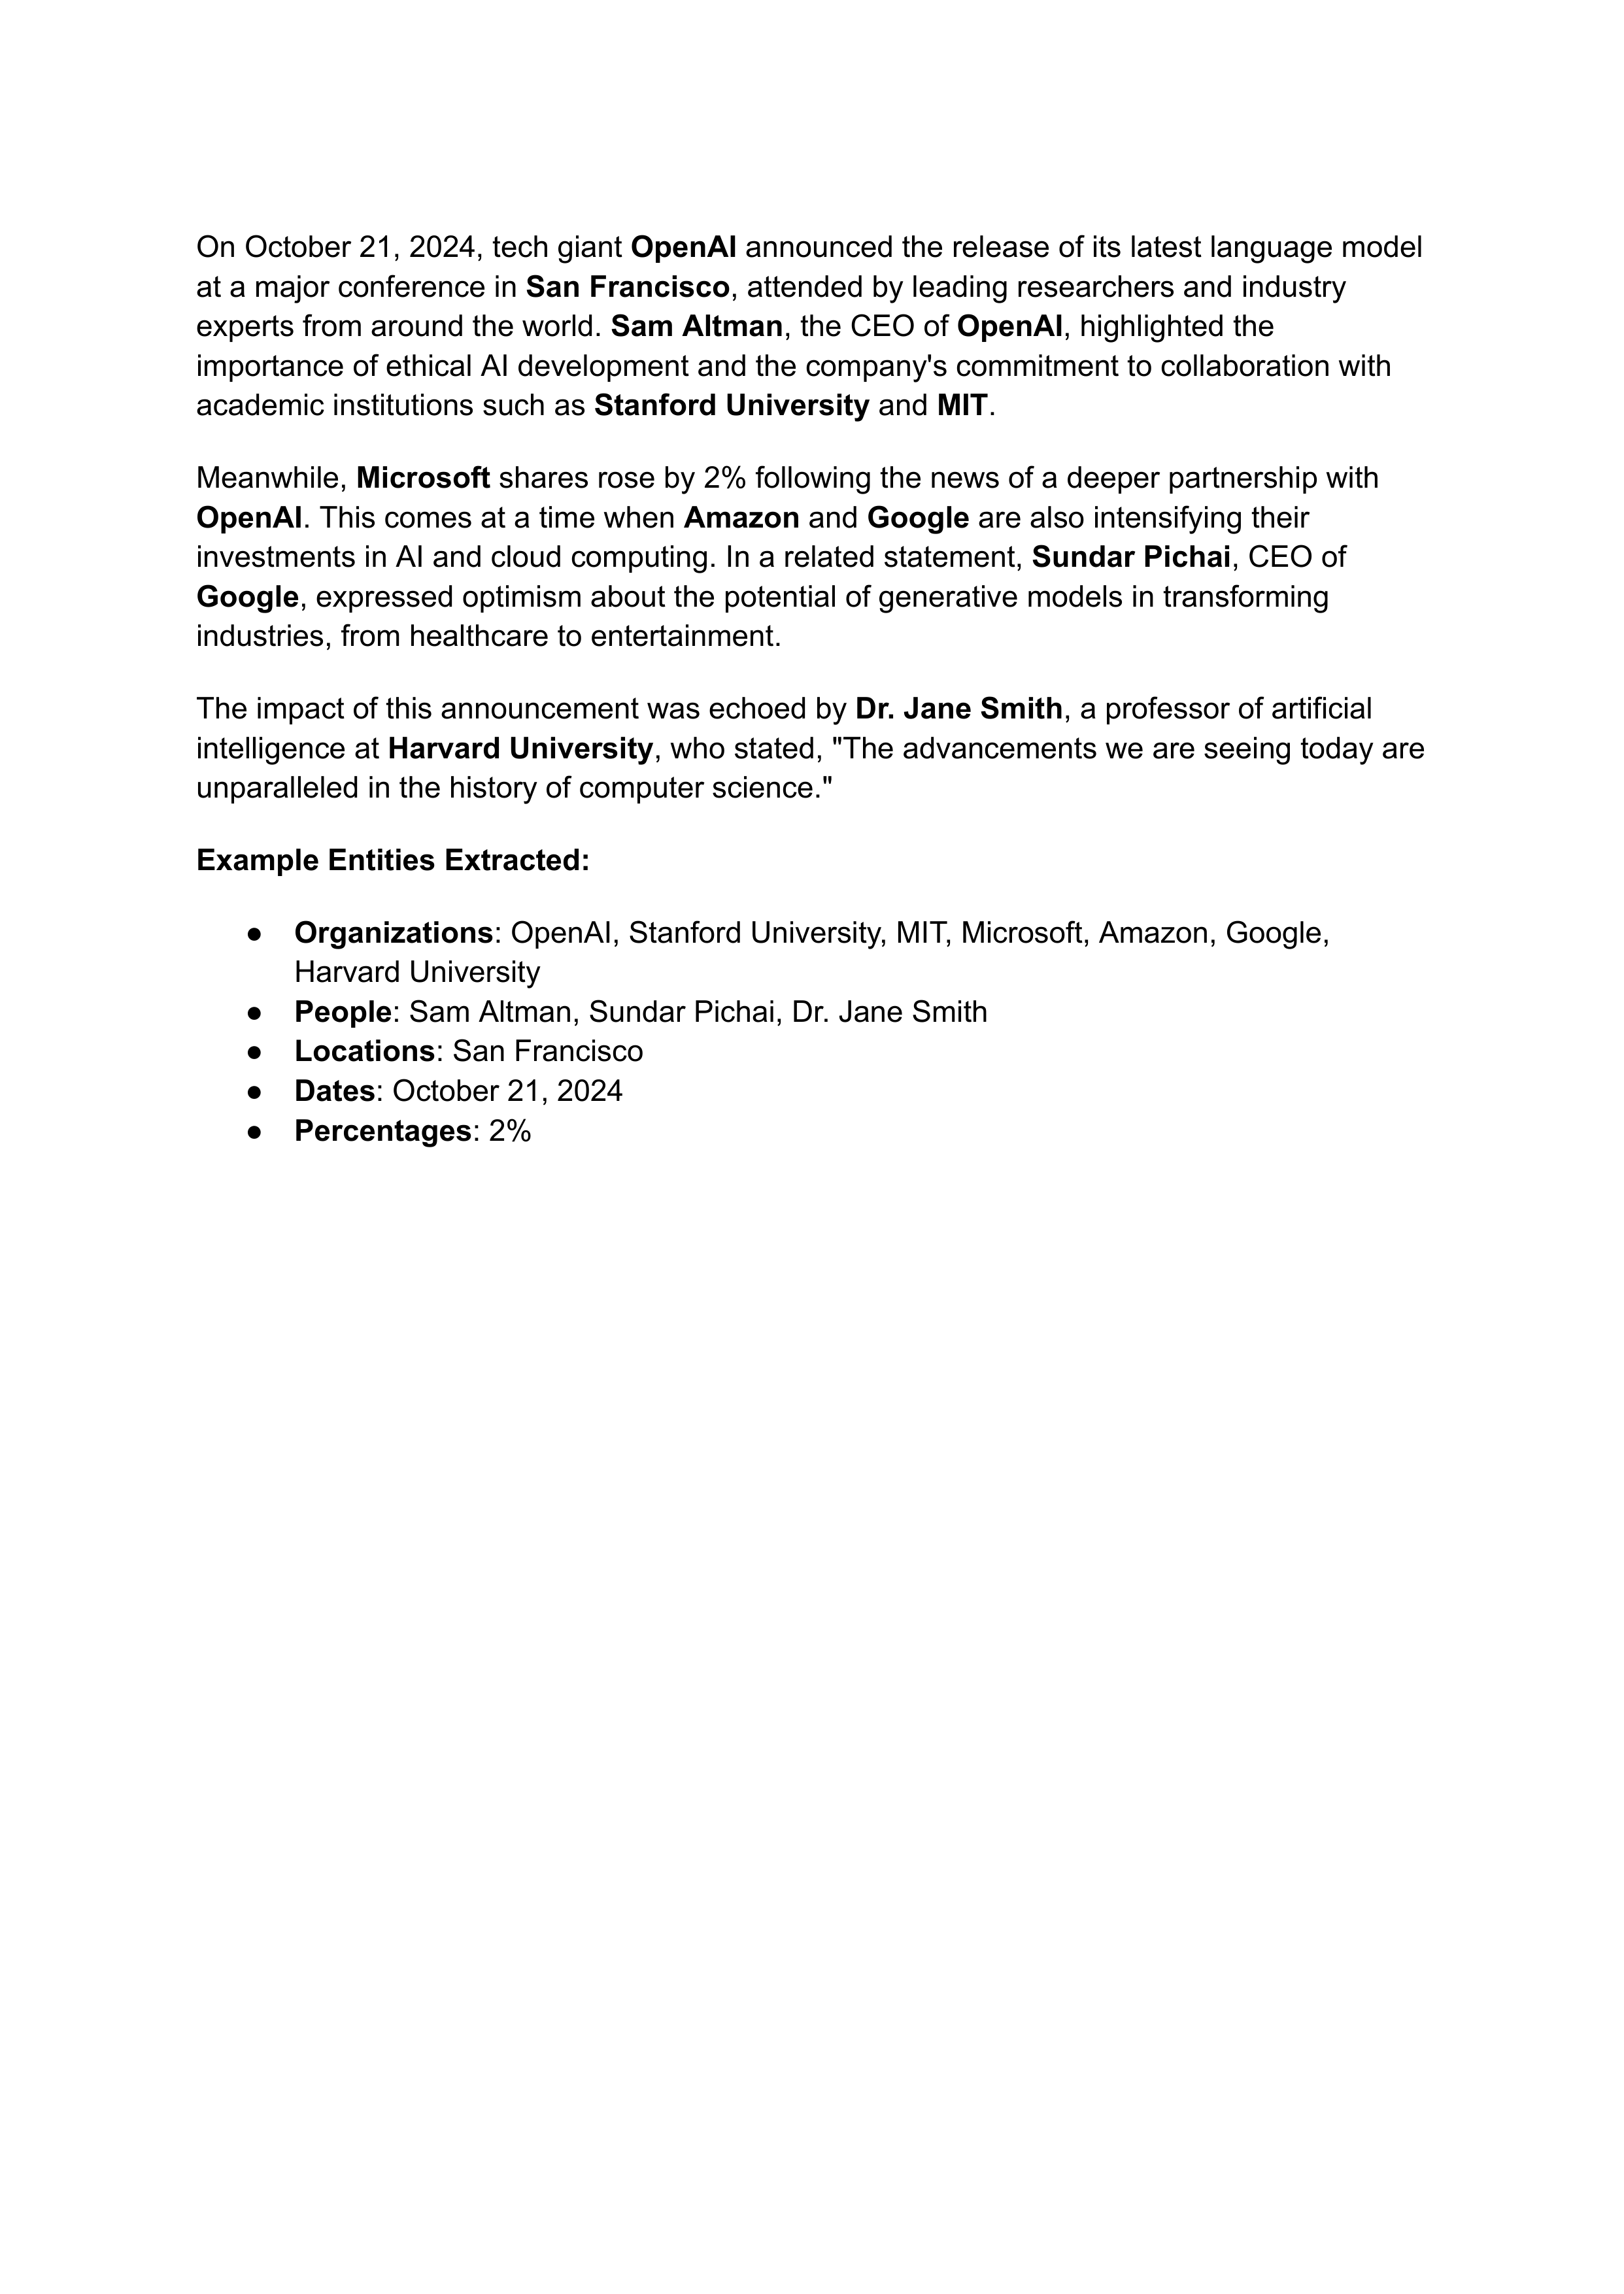

In [2]:
pdf_example = files('resources/pdfs/example.pdf')

df = spark.read.format("binaryFile") \
    .load(pdf_example)

df.show_pdf()

## Define pipeline for extract text from the PDF and call it

In [3]:
pipeline = PipelineModel(stages=[
    PdfDataToImage(),
    TesseractOcr(keepFormatting=True, psm=PSM.SPARSE_TEXT)
])

result = pipeline.transform(df).cache()
result.show()

+--------------------+--------------------+------+----+--------------------+
|                path|    modificationTime|length|page|                text|
+--------------------+--------------------+------+----+--------------------+
|file:/home/nmelni...|2024-11-18 19:06:...| 48025|   0|{file:/home/nmeln...|
+--------------------+--------------------+------+----+--------------------+


## Show schema of result DataFrame

In [4]:
result.printSchema()

root
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- page: integer (nullable = true)
 |-- text: struct (nullable = true)
 |    |-- path: string (nullable = false)
 |    |-- text: string (nullable = false)
 |    |-- type: string (nullable = false)
 |    |-- bboxes: array (nullable = false)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- text: string (nullable = false)
 |    |    |    |-- score: double (nullable = false)
 |    |    |    |-- x: integer (nullable = false)
 |    |    |    |-- y: integer (nullable = false)
 |    |    |    |-- width: integer (nullable = false)
 |    |    |    |-- height: integer (nullable = false)
 |    |-- exception: string (nullable = false)


## Show coordinates for each word

In [5]:
from pyspark.sql.functions import  explode
result.select(explode("text.bboxes").alias("bboxes")).select("bboxes.*").show()

+----------+------------------+----+---+-----+------+
|      text|             score|   x|  y|width|height|
+----------+------------------+----+---+-----+------+
|        On|0.9560096699999999| 302|360|   56|    34|
|   October|0.9560096699999999| 376|360|  161|    34|
|       21,|0.9672520400000001| 551|360|   58|    39|
|     2024,|        0.96345642| 627|360|  109|    39|
|      tech|        0.96555283| 754|360|   83|    34|
|     giant|         0.9262767| 854|360|   97|    43|
|    OpenAl|0.9045816000000001| 966|360|  158|    42|
| announced|        0.96029114|1142|360|  222|    34|
|       the|0.9671869700000001|1380|360|   61|    34|
|   release|        0.96110672|1459|360|  145|    34|
|        of|        0.96110672|1621|360|   38|    34|
|       its|        0.96443901|1673|360|   41|    34|
|    latest|0.9605590100000001|1731|360|  106|    34|
|  language|0.9576543399999999|1853|360|  184|    43|
|     model|        0.96557098|2054|360|  119|    34|
|     major|0.96843245999999

## Show recognized text

In [6]:
result.show_text()

## Collect recognized text to the local variable

In [7]:
text = result.select("text.text").collect()[0][0]
print(text)





             On October 21, 2024, tech giant OpenAl announced the release of its latest language model
             at a major conference in San Francisco, attended by leading researchers and industry
             experts from around the world. Sam Altman, the CEO of OpenAl, highlighted the
             importance of ethical Al development and the company's commitment to collaboration with
             academic institutions such as Stanford University and MIT.
             Meanwhile, Microsoft shares rose by 2% following the news of a deeper partnership with
                      This comes at a time when Amazon and Google are also intensifying their
             investments in Al and cloud computing. In a related statement, Sundar Pichai, CEO of
             Google, expressed optimism about the potential of generative models in transforming
             industries, from healthcare to entertainment.
             The impact of this announcement was echoed by Dr. Jane Smith, a profes